In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
df = pd.read_csv("sequence_with_lag_features_cancel_out.csv")

In [ ]:
df["is_holiday"] = df["is_holiday"].replace({False: 0, True: 1})
df["1y_holiday_diff"] = df["1y_holiday_diff"].fillna(0)

/tmp/nix-shell.WupKFT/ipykernel_1635050/1172609422.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["is_holiday"] = df["is_holiday"].replace({False: 0, True: 1})


,user_id,year_month,txn_count_prev,total_expense_prev,mean_amount,user_gender,user_current_age,user_yearly_income,user_per_capita_income,user_credit_score,...,lag_2_spending,lag_3_spending,lag_5_spending,lag_6_spending,lag_7_spending,lag_9_spending,lag_11_spending,lag_12_spending,1y_holiday_diff,is_holiday
0,0,2015-01-01,128.0,6185.2,53.0,0,33,59613.0,29237.0,763,...,3859.24,6766.18,4266.63,6777.58,6604.68,5055.62,5109.56,6169.59,-1252.72,1
1,0,2015-02-01,99.0,5249.9,49.2,0,33,59613.0,29237.0,763,...,7091.15,3859.24,5642.49,4266.63,6777.58,7068.70,4600.44,5109.56,-739.90,1
2,0,2015-03-01,86.0,4229.7,45.5,0,33,59613.0,29237.0,763,...,4916.87,7091.15,6766.18,5642.49,4266.63,6604.68,5055.62,4600.44,0.00,0
3,0,2015-04-01,101.0,4595.4,47.8,0,33,59613.0,29237.0,763,...,4369.66,4916.87,3859.24,6766.18,5642.49,6777.58,7068.70,5055.62,0.00,0
4,0,2015-05-01,96.0,4586.5,50.6,0,33,59613.0,29237.0,763,...,5495.42,4369.66,7091.15,3859.24,6766.18,4266.63,6604.68,7068.70,-1420.57,1
5,0,2015-06-01,116.0,5864.1,57.6,0,33,59613.0,29237.0,763,...,4938.54,5495.42,4916.87,7091.15,3859.24,5642.49,6777.58,6604.68,0.00,0
6,0,2015-07-01,106.0,6104.9,59.8,0,33,59613.0,29237.0,763,...,5648.13,4938.54,4369.66,4916.87,7091.15,6766.18,4266.63,6777.58,-1133.53,1
7,0,2015-08-01,92.0,5504.1,48.8,0,33,59613.0,29237.0,763,...,5886.93,5648.13,5495.42,4369.66,4916.87,3859.24,5642.49,4266.63,0.00,0
8,0,2015-09-01,103.0,5029.5,56.7,0,33,59613.0,29237.0,763,...,5644.05,5886.93,4938.54,5495.42,4369.66,7091.15,6766.18,5642.49,67.42,1
9,0,2015-10-01,94.0,5329.9,58.9,0,33,59613.0,29237.0,763,...,5029.51,5644.05,5648.13,4938.54,5495.42,4916.87,3859.24,6766.18,-495.02,1


In [5]:
df["year_month"] = pd.to_datetime(df["year_month"])

"""
The new setup for datasets and dataloaders
"""

train_end = pd.Timestamp("2017-12-31")
val_end = pd.Timestamp("2018-12-31")
test_end = pd.Timestamp("2019-09-30")

train_mask = df["year_month"] <= train_end
val_mask = (df["year_month"] > train_end) & (df["year_month"] <= val_end)
test_mask = (df["year_month"] > val_end) & (df["year_month"] <= test_end)

train_df = df.loc[train_mask].copy()
val_df = df.loc[val_mask].copy()
test_df = df.loc[test_mask].copy()


print(len(train_df), len(val_df), len(test_df))

43305 14454 10852


In [6]:
num_cols = [
    "total_expense_prev",
    "user_yearly_income",
    "user_per_capita_income",
    "user_credit_score",
    "user_total_debt",
    "income_per_card",
    "mean_amount",
]
# --- normalize ---
scaler = StandardScaler()
scaler.fit(train_df[num_cols])

df_scaled = df.copy()
df_scaled[num_cols] = scaler.transform(df_scaled[num_cols])

In [7]:
class TransactionDataset(Dataset):
    def __init__(
        self,
        df,
        feature_cols,
        user_col="user_id",
        date_col="year_month",
        target_col="mean_amount",
        window_size=12,
        target_start=None,
        target_end=None,
    ):
        self.feature_cols = feature_cols
        self.user_col = user_col
        self.date_col = date_col
        self.target_col = target_col
        self.window_size = window_size
        self.samples = []

        ts = pd.to_datetime(target_start) if target_start is not None else None
        te = pd.to_datetime(target_end) if target_end is not None else None
        if ts is None:
            ts = df[date_col].min()
        if te is None:
            te = df[date_col].max()

        for _, g in df.groupby(user_col):
            """
            We use previous 12 months of data to predict the target month, even if the history
            crosses the train/val/test boundaries
            """
            g = g.sort_values(date_col).reset_index(drop=True)
            Xmat = g[self.feature_cols].to_numpy(dtype=float)
            yvec = g[self.target_col].to_numpy(dtype=float)
            months = g[date_col].to_numpy()

            for i in range(window_size, len(g)):
                t_month = months[i]
                if t_month < ts or t_month > te:
                    continue
                X = Xmat[i - window_size : i]
                y = float(yvec[i])
                self.samples.append((X, y))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        X, y = self.samples[idx]
        return (torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))

In [8]:
class TransformerAmountPredictor(nn.Module):
    def __init__(self, num_features, hidden_dim=128, num_layers=2, nhead=4, dropout=0.2):
        super().__init__()
        self.input_proj = nn.Linear(num_features, hidden_dim)
        # Learnable positional encoding, assuming max sequence length of 50 (window_size is 12)
        self.pos_embedding = nn.Parameter(torch.randn(1, 50, hidden_dim) * 0.01)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=nhead, dim_feedforward=hidden_dim * 4, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: [batch, seq_len, num_features]
        B, L, _ = x.shape
        x = self.input_proj(x) + self.pos_embedding[:, :L, :]
        out = self.transformer_encoder(x)
        last_out = out[:, -1, :]  # [batch, hidden_dim]
        y_pred = self.fc(last_out)  # [batch, 1]
        return y_pred.squeeze(-1)

In [9]:
feature_cols = [
    "txn_count_prev",
    "total_expense_prev",
    "user_gender",
    "user_current_age",
    "user_yearly_income",
    "user_per_capita_income",
    "user_credit_score",
    "user_total_debt",
    "user_birth_month",
    "card_num_cards_issued",
    "user_latitude",
    "user_longitude",
    "year_to_retirement",
    "debt_to_yearly_income_ratio",
    "income_per_card",
    "multi_card_user",
    "income_utilization_ratio",
    "credit_utilization_ratio",
    "oldest_card_age_years",
    "percentage_prev_monthly_expense_as_yearly",
    "percentage_prev_monthly_expense_as_capita",
    "1y_holiday_diff",
    "is_holiday",
]


"""
The new setup for datasets and dataloaders
"""
train_target_start = df["year_month"].min() + pd.offsets.MonthBegin(0)
train_target_end = train_end
val_target_start = train_end + pd.offsets.Day(1)
val_target_end = val_end
test_target_start = val_end + pd.offsets.Day(1)
test_target_end = test_end

In [10]:
num_features = len(feature_cols)
model = TransformerAmountPredictor(num_features=num_features, hidden_dim=128, num_layers=2, nhead=4, dropout=0.1)
# hyperparam
BATCH_SIZE = 128
EPOCHS = 50
LR = 1e-3
PATIENCE = 6

"""
The new setup for datasets and dataloaders
"""
train_dataset = TransactionDataset(
    df=df_scaled,
    feature_cols=feature_cols,
    window_size=12,
    target_start=train_target_start,
    target_end=train_target_end,
    target_col="mean_amount",
)
val_dataset = TransactionDataset(
    df=df_scaled,
    feature_cols=feature_cols,
    window_size=12,
    target_start=val_target_start,
    target_end=val_target_end,
    target_col="mean_amount",
)
test_dataset = TransactionDataset(
    df=df_scaled,
    feature_cols=feature_cols,
    window_size=12,
    target_start=test_target_start,
    target_end=test_target_end,
    target_col="mean_amount",
)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

best_val_loss = np.inf
patience_counter = 0

Epoch 1/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 302.66it/s]



📘 Epoch 01 | Train Loss: 0.632458 | Val Loss: 0.591858 | test Loss: 0.614501
✅ Saved new best model (val_loss=0.591858)


Epoch 2/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 309.10it/s]



📘 Epoch 02 | Train Loss: 0.495170 | Val Loss: 0.380124 | test Loss: 0.383794
✅ Saved new best model (val_loss=0.380124)


Epoch 3/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 313.80it/s]



📘 Epoch 03 | Train Loss: 0.330686 | Val Loss: 0.274988 | test Loss: 0.279182
✅ Saved new best model (val_loss=0.274988)


Epoch 4/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 308.15it/s]



📘 Epoch 04 | Train Loss: 0.273573 | Val Loss: 0.275730 | test Loss: 0.283324
 No improvement (1/6)


Epoch 5/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 306.02it/s]



📘 Epoch 05 | Train Loss: 0.254165 | Val Loss: 0.234222 | test Loss: 0.239192
✅ Saved new best model (val_loss=0.234222)


Epoch 6/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 292.34it/s]



📘 Epoch 06 | Train Loss: 0.245117 | Val Loss: 0.225642 | test Loss: 0.232361
✅ Saved new best model (val_loss=0.225642)


Epoch 7/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 311.84it/s]



📘 Epoch 07 | Train Loss: 0.243760 | Val Loss: 0.225526 | test Loss: 0.226740
✅ Saved new best model (val_loss=0.225526)


Epoch 8/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 310.95it/s]



📘 Epoch 08 | Train Loss: 0.232843 | Val Loss: 0.247339 | test Loss: 0.255563
 No improvement (1/6)


Epoch 9/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 306.46it/s]



📘 Epoch 09 | Train Loss: 0.232125 | Val Loss: 0.204448 | test Loss: 0.210030
✅ Saved new best model (val_loss=0.204448)


Epoch 10/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 298.68it/s]



📘 Epoch 10 | Train Loss: 0.224497 | Val Loss: 0.209906 | test Loss: 0.215660
 No improvement (1/6)


Epoch 11/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 303.01it/s]



📘 Epoch 11 | Train Loss: 0.223497 | Val Loss: 0.241063 | test Loss: 0.244238
 No improvement (2/6)


Epoch 12/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 313.25it/s]



📘 Epoch 12 | Train Loss: 0.219013 | Val Loss: 0.204786 | test Loss: 0.211371
 No improvement (3/6)


Epoch 13/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 318.91it/s]



📘 Epoch 13 | Train Loss: 0.207915 | Val Loss: 0.204952 | test Loss: 0.209213
 No improvement (4/6)


Epoch 14/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 313.98it/s]



📘 Epoch 14 | Train Loss: 0.206974 | Val Loss: 0.241000 | test Loss: 0.245251
 No improvement (5/6)


Epoch 15/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 271.11it/s]




📘 Epoch 15 | Train Loss: 0.204269 | Val Loss: 0.196640 | test Loss: 0.202001
✅ Saved new best model (val_loss=0.196640)


Epoch 16/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 300.18it/s]



📘 Epoch 16 | Train Loss: 0.203806 | Val Loss: 0.197584 | test Loss: 0.202186
 No improvement (1/6)


Epoch 17/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 307.05it/s]



📘 Epoch 17 | Train Loss: 0.202113 | Val Loss: 0.202614 | test Loss: 0.209044
 No improvement (2/6)


Epoch 18/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 312.95it/s]



📘 Epoch 18 | Train Loss: 0.201794 | Val Loss: 0.192617 | test Loss: 0.196168
✅ Saved new best model (val_loss=0.192617)


Epoch 19/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 311.53it/s]



📘 Epoch 19 | Train Loss: 0.200943 | Val Loss: 0.187630 | test Loss: 0.191829
✅ Saved new best model (val_loss=0.187630)


Epoch 20/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 308.59it/s]



📘 Epoch 20 | Train Loss: 0.198021 | Val Loss: 0.196725 | test Loss: 0.198194
 No improvement (1/6)


Epoch 21/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 300.43it/s]



📘 Epoch 21 | Train Loss: 0.196191 | Val Loss: 0.215778 | test Loss: 0.217374
 No improvement (2/6)


Epoch 22/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 308.91it/s]



📘 Epoch 22 | Train Loss: 0.198628 | Val Loss: 0.185680 | test Loss: 0.190284
✅ Saved new best model (val_loss=0.185680)


Epoch 23/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 317.86it/s]



📘 Epoch 23 | Train Loss: 0.192447 | Val Loss: 0.186880 | test Loss: 0.194292
 No improvement (1/6)


Epoch 24/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 301.08it/s]



📘 Epoch 24 | Train Loss: 0.191644 | Val Loss: 0.203048 | test Loss: 0.211388
 No improvement (2/6)


Epoch 25/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 307.26it/s]



📘 Epoch 25 | Train Loss: 0.187035 | Val Loss: 0.178456 | test Loss: 0.181090
✅ Saved new best model (val_loss=0.178456)


Epoch 26/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 299.67it/s]



📘 Epoch 26 | Train Loss: 0.186962 | Val Loss: 0.182406 | test Loss: 0.184115
 No improvement (1/6)


Epoch 27/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 298.55it/s]



📘 Epoch 27 | Train Loss: 0.188007 | Val Loss: 0.171296 | test Loss: 0.175026
✅ Saved new best model (val_loss=0.171296)


Epoch 28/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 308.05it/s]



📘 Epoch 28 | Train Loss: 0.182591 | Val Loss: 0.189887 | test Loss: 0.199306
 No improvement (1/6)


Epoch 29/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 295.44it/s]



📘 Epoch 29 | Train Loss: 0.183397 | Val Loss: 0.168806 | test Loss: 0.173345
✅ Saved new best model (val_loss=0.168806)


Epoch 30/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 296.41it/s]



📘 Epoch 30 | Train Loss: 0.183385 | Val Loss: 0.171071 | test Loss: 0.176542
 No improvement (1/6)


Epoch 31/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 298.46it/s]



📘 Epoch 31 | Train Loss: 0.184683 | Val Loss: 0.174493 | test Loss: 0.177630
 No improvement (2/6)


Epoch 32/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 310.28it/s]



📘 Epoch 32 | Train Loss: 0.178654 | Val Loss: 0.179167 | test Loss: 0.180890
 No improvement (3/6)


Epoch 33/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 293.27it/s]



📘 Epoch 33 | Train Loss: 0.173418 | Val Loss: 0.168696 | test Loss: 0.173345
✅ Saved new best model (val_loss=0.168696)


Epoch 34/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 306.46it/s]



📘 Epoch 34 | Train Loss: 0.173405 | Val Loss: 0.167236 | test Loss: 0.170629
✅ Saved new best model (val_loss=0.167236)


Epoch 35/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 306.63it/s]



📘 Epoch 35 | Train Loss: 0.172222 | Val Loss: 0.166977 | test Loss: 0.170942
✅ Saved new best model (val_loss=0.166977)


Epoch 36/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 307.71it/s]



📘 Epoch 36 | Train Loss: 0.173173 | Val Loss: 0.169202 | test Loss: 0.173684
 No improvement (1/6)


Epoch 37/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 292.10it/s]



📘 Epoch 37 | Train Loss: 0.173211 | Val Loss: 0.169984 | test Loss: 0.174844
 No improvement (2/6)


Epoch 38/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 308.81it/s]



📘 Epoch 38 | Train Loss: 0.173928 | Val Loss: 0.172052 | test Loss: 0.175697
 No improvement (3/6)


Epoch 39/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 306.37it/s]



📘 Epoch 39 | Train Loss: 0.170385 | Val Loss: 0.170050 | test Loss: 0.172567
 No improvement (4/6)


Epoch 40/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 306.23it/s]



📘 Epoch 40 | Train Loss: 0.169404 | Val Loss: 0.171330 | test Loss: 0.174560
 No improvement (5/6)


Epoch 41/50 [Test]: 100%|██████████| 85/85 [00:00<00:00, 300.72it/s]




📘 Epoch 41 | Train Loss: 0.169907 | Val Loss: 0.167939 | test Loss: 0.172435
 No improvement (6/6)
⏹️ Early stopping triggered


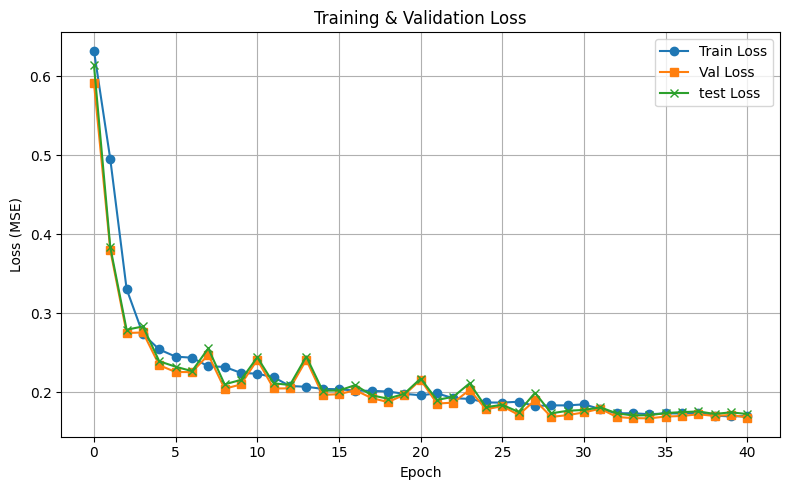

In [11]:
train_history = {"train_loss": [], "val_loss": [], "test_loss": []}
for epoch in range(EPOCHS):
    model.train()
    train_losses = []
    for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        preds = model(X).squeeze()  # (batch,)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)

    model.eval()
    val_losses = []
    with torch.no_grad():
        for X, y in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            X, y = X.to(device), y.to(device)
            preds = model(X).squeeze()
            loss = criterion(preds, y)
            val_losses.append(loss.item())

    avg_val_loss = np.mean(val_losses)
    test_losses = []
    with torch.no_grad():
        for X, y in tqdm(test_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Test]"):
            X, y = X.to(device), y.to(device)
            preds = model(X).squeeze()
            loss = criterion(preds, y)
            test_losses.append(loss.item())

    avg_test_loss = np.mean(test_losses)

    train_history["train_loss"].append(avg_train_loss)
    train_history["val_loss"].append(avg_val_loss)
    train_history["test_loss"].append(avg_test_loss)

    # Step the scheduler
    scheduler.step(avg_val_loss)

    print(
        f"\n📘 Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | test Loss: {avg_test_loss:.6f}"
    )

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_transformer.pt")
        print(f"✅ Saved new best model (val_loss={best_val_loss:.6f})")
    else:
        patience_counter += 1
        print(f" No improvement ({patience_counter}/{PATIENCE})")
        if patience_counter >= PATIENCE:
            print("⏹️ Early stopping triggered")
            break


plt.figure(figsize=(8, 5))
plt.plot(train_history["train_loss"], label="Train Loss", marker="o")
plt.plot(train_history["val_loss"], label="Val Loss", marker="s")
plt.plot(train_history["test_loss"], label="test Loss", marker="x")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
model.load_state_dict(torch.load("best_transformer.pt"))
model.to(device)
model.eval()


def evaluate_model(loader, model, device, scaler, target_col_idx):
    y_true, y_pred = [], []
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            preds = model(X).squeeze()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    y_true, y_pred = np.array(y_true), np.array(y_pred)

    # Inverse transform to get back to original dollar amount
    # y_orig = y_scaled * std + mean
    target_mean = scaler.mean_[target_col_idx]
    target_scale = scaler.scale_[target_col_idx]

    y_true_orig = (y_true * target_scale) + target_mean
    y_pred_orig = (y_pred * target_scale) + target_mean

    mae = mean_absolute_error(y_true_orig, y_pred_orig)
    mse = mean_squared_error(y_true_orig, y_pred_orig)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true_orig - y_pred_orig) / (y_true_orig + 1e-8))) * 100

    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "MAPE": mape}


target_idx = num_cols.index("mean_amount")
val_metrics = evaluate_model(val_loader, model, device, scaler, target_idx)
print("\n📊 Validation Set Metrics (Original Scale):")
for k, v in val_metrics.items():
    print(f"  {k}: {v:.6f}")

test_metrics = evaluate_model(test_loader, model, device, scaler, target_idx)
print("\n📊 Test Set Metrics (Original Scale):")
for k, v in test_metrics.items():
    print(f"  {k}: {v:.6f}")


📊 Validation Set Metrics (Original Scale):
  MAE: 6.696706
  MSE: 93.239571
  RMSE: 9.656064
  MAPE: 14.645064

📊 Test Set Metrics (Original Scale):
  MAE: 6.772457
  MSE: 95.469651
  RMSE: 9.770857
  MAPE: 15.008316

📊 Test Set Metrics (Original Scale):
  MAE: 6.772457
  MSE: 95.469651
  RMSE: 9.770857
  MAPE: 15.008316


# Experiment with Transformer 

*   **Model Architecture**
    *   Scaled down positional embedding initialization ($\sigma=0.01$) so it doesn't overwhelm input features.
    *   Increased `dropout` to **0.2** to fight overfitting
*   **Feature Engineering**
    *   Dropped manual features like `weekend_spend_ratio` and `lag_*`, letting the Transformer figure it out.
    *   Scaled `mean_amount` (target) to prevent instability from large value ranges.
*   **Training**
    *   Added `ReduceLROnPlateau` to lower LR when loss stops improving.